
Global SVM Report
                      precision    recall  f1-score   support

          AnnualCrop       0.76      0.83      0.79       573
              Forest       0.81      0.81      0.81       575
HerbaceousVegetation       0.74      0.75      0.75       621
             Highway       0.52      0.39      0.44       504
          Industrial       0.89      0.90      0.90       501
             Pasture       0.76      0.72      0.74       397
       PermanentCrop       0.68      0.65      0.66       504
         Residential       0.77      0.76      0.77       608
               River       0.61      0.69      0.64       511
             SeaLake       0.81      0.85      0.83       606

            accuracy                           0.74      5400
           macro avg       0.73      0.74      0.73      5400
        weighted avg       0.74      0.74      0.74      5400


Local SVM Report
                      precision    recall  f1-score   support

          AnnualCrop       0.

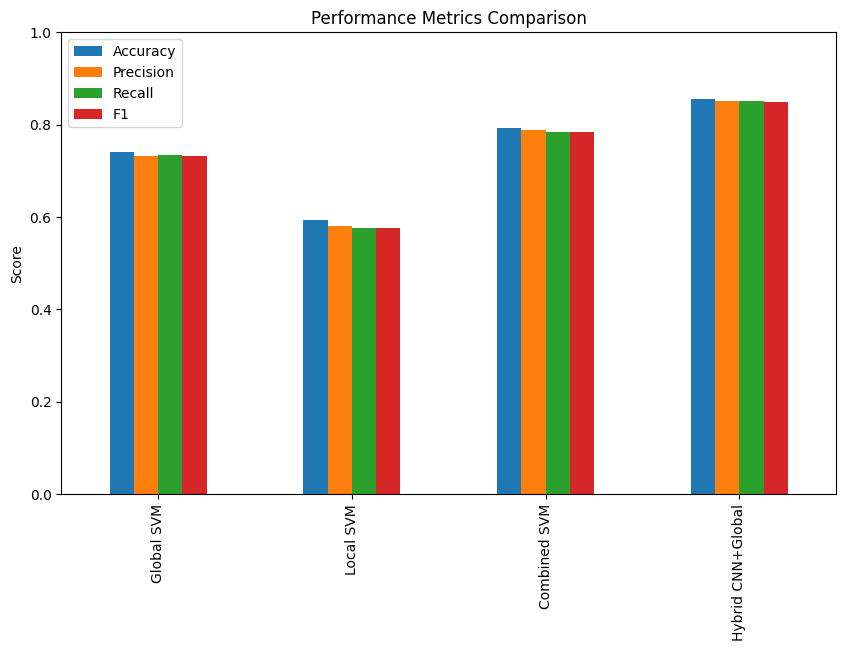

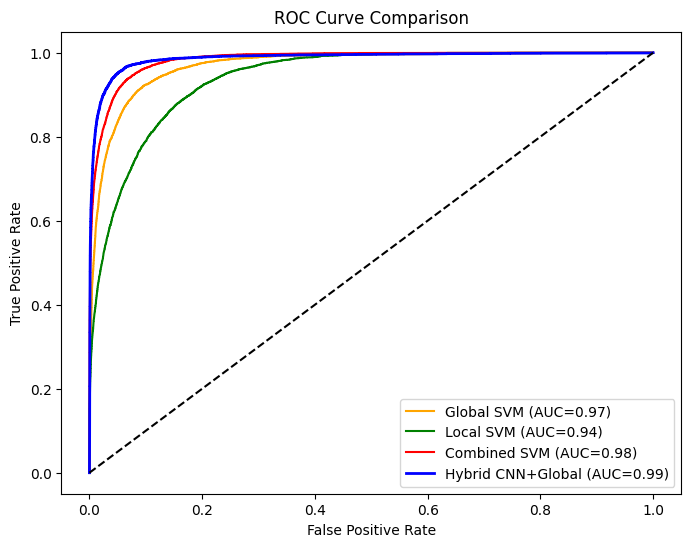

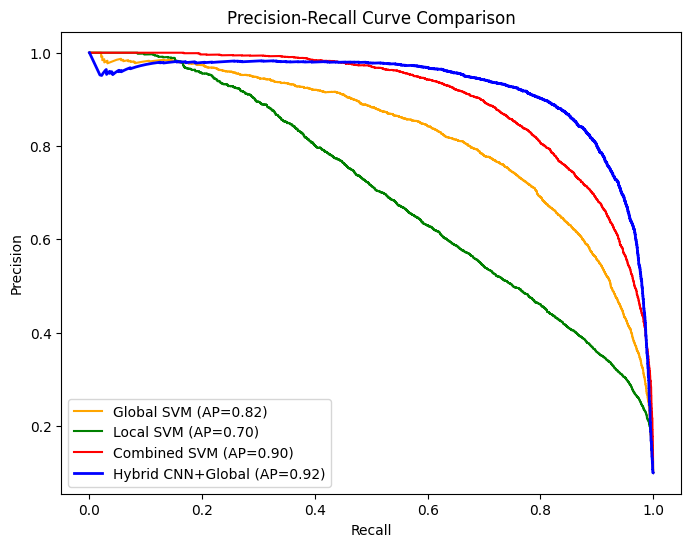

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras import layers, models, Input

# ==========================
# 1. Load EuroSAT Dataset (80/20 split)
# ==========================
train_ds = tfds.load("eurosat/rgb", split="train[:80%]", as_supervised=True)
test_ds  = tfds.load("eurosat/rgb", split="train[80%:]", as_supervised=True)

info = tfds.builder("eurosat/rgb").info
class_names = info.features["label"].names
n_classes = len(class_names)

def tf_to_numpy(ds, img_size=(64,64)):
    X, y = [], []
    for img, label in tfds.as_numpy(ds):
        img_resized = cv2.resize(img, img_size)
        X.append(img_resized)
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = tf_to_numpy(train_ds)
X_test, y_test = tf_to_numpy(test_ds)

X_train_norm = X_train.astype("float32") / 255.0
X_test_norm = X_test.astype("float32") / 255.0

# ==========================
# 2. Feature Extraction
# ==========================
def extract_global_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, [8,8,8], [0,180,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_local_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm="L2-Hys")
    return features

Xg_train = np.array([extract_global_features(img) for img in X_train])
Xg_test = np.array([extract_global_features(img) for img in X_test])
Xl_train = np.array([extract_local_features(img) for img in X_train])
Xl_test = np.array([extract_local_features(img) for img in X_test])

Xc_train = np.hstack([Xg_train, Xl_train])
Xc_test = np.hstack([Xg_test, Xl_test])

# Normalize
scaler = StandardScaler()
Xg_train = scaler.fit_transform(Xg_train); Xg_test = scaler.transform(Xg_test)
Xl_train = scaler.fit_transform(Xl_train); Xl_test = scaler.transform(Xl_test)
Xc_train = scaler.fit_transform(Xc_train); Xc_test = scaler.transform(Xc_test)

# ==========================
# 3. Train SVM Models
# ==========================
def train_svm(X_train, y_train, X_test, y_test, name="Model"):
    clf = SVC(kernel="linear", probability=True, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    print(f"\n{name} Report")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    return clf, {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}, y_pred, clf.predict_proba(X_test)

model_g, metrics_g, y_pred_g, prob_g = train_svm(Xg_train, y_train, Xg_test, y_test, "Global SVM")
model_l, metrics_l, y_pred_l, prob_l = train_svm(Xl_train, y_train, Xl_test, y_test, "Local SVM")
model_c, metrics_c, y_pred_c, prob_c = train_svm(Xc_train, y_train, Xc_test, y_test, "Combined SVM")

# ==========================
# 4. Hybrid CNN + Global Model
# ==========================
global_input_dim = Xg_train.shape[1]

cnn_input = Input(shape=(64,64,3))
x = layers.Conv2D(32, (3,3), activation="relu")(cnn_input)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)

global_input = Input(shape=(global_input_dim,))
y = layers.Dense(128, activation="relu")(global_input)

combined = layers.concatenate([x, y])
z = layers.Dense(128, activation="relu")(combined)
output = layers.Dense(n_classes, activation="softmax")(z)

hybrid_model = models.Model(inputs=[cnn_input, global_input], outputs=output)
hybrid_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = hybrid_model.fit(
    [X_train_norm, Xg_train], y_train,
    validation_data=([X_test_norm, Xg_test], y_test),
    epochs=10, batch_size=64, verbose=1
)

y_pred_probs_hybrid = hybrid_model.predict([X_test_norm, Xg_test])
y_pred_hybrid = np.argmax(y_pred_probs_hybrid, axis=1)

acc = accuracy_score(y_test, y_pred_hybrid)
prec = precision_score(y_test, y_pred_hybrid, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred_hybrid, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred_hybrid, average="macro", zero_division=0)
metrics_hybrid = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

print("\nHybrid CNN+Global Report")
print(classification_report(y_test, y_pred_hybrid, target_names=class_names, zero_division=0))

# ==========================
# 5. Compare Metrics
# ==========================
comparison_df = pd.DataFrame({
    "Global SVM": metrics_g,
    "Local SVM": metrics_l,
    "Combined SVM": metrics_c,
    "Hybrid CNN+Global": metrics_hybrid
})
print("\nPerformance Comparison:")
print(comparison_df)

comparison_df.T.plot(kind="bar", figsize=(10,6))
plt.title("Performance Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

# ==========================
# 6. ROC Curves
# ==========================
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr_g, tpr_g, _ = roc_curve(y_test_bin.ravel(), prob_g.ravel())
roc_auc_g = auc(fpr_g, tpr_g)

fpr_l, tpr_l, _ = roc_curve(y_test_bin.ravel(), prob_l.ravel())
roc_auc_l = auc(fpr_l, tpr_l)

fpr_c, tpr_c, _ = roc_curve(y_test_bin.ravel(), prob_c.ravel())
roc_auc_c = auc(fpr_c, tpr_c)

fpr_h, tpr_h, _ = roc_curve(y_test_bin.ravel(), y_pred_probs_hybrid.ravel())
roc_auc_h = auc(fpr_h, tpr_h)

plt.figure(figsize=(8,6))
plt.plot(fpr_g, tpr_g, label=f"Global SVM (AUC={roc_auc_g:.2f})", color="orange")
plt.plot(fpr_l, tpr_l, label=f"Local SVM (AUC={roc_auc_l:.2f})", color="green")
plt.plot(fpr_c, tpr_c, label=f"Combined SVM (AUC={roc_auc_c:.2f})", color="red")
plt.plot(fpr_h, tpr_h, label=f"Hybrid CNN+Global (AUC={roc_auc_h:.2f})", color="blue", linewidth=2)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# ==========================
# 7. Precision-Recall Curves
# ==========================
precision_g, recall_g, _ = precision_recall_curve(y_test_bin.ravel(), prob_g.ravel())
ap_g = average_precision_score(y_test_bin, prob_g, average="micro")

precision_l, recall_l, _ = precision_recall_curve(y_test_bin.ravel(), prob_l.ravel())
ap_l = average_precision_score(y_test_bin, prob_l, average="micro")

precision_c, recall_c, _ = precision_recall_curve(y_test_bin.ravel(), prob_c.ravel())
ap_c = average_precision_score(y_test_bin, prob_c, average="micro")

precision_h, recall_h, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_probs_hybrid.ravel())
ap_h = average_precision_score(y_test_bin, y_pred_probs_hybrid, average="micro")

plt.figure(figsize=(8,6))
plt.plot(recall_g, precision_g, label=f"Global SVM (AP={ap_g:.2f})", color="orange")
plt.plot(recall_l, precision_l, label=f"Local SVM (AP={ap_l:.2f})", color="green")
plt.plot(recall_c, precision_c, label=f"Combined SVM (AP={ap_c:.2f})", color="red")
plt.plot(recall_h, precision_h, label=f"Hybrid CNN+Global (AP={ap_h:.2f})", color="blue", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()
